In [2]:
import pandas as pd

from data_preparation import (
    download_gios_archive,
    split_raw_df_to_metadata_and_measurements,
    download_updated_metadata,
    build_station_code_mapping,
    update_station_names_metadata,
    update_station_names_data,
    extend_metadata_with_station_info,
    combine_metadata_frames,
    combine_data_frames,
)
from statistics_calculation import (
    analyze_raw_df,
    check_timestamps,
    report_nan_runs,
    monthly_avg_with_nan_threshold,
    average_by_city,
    count_days_over_threshold,
)
from visualizations import (
    plot_monthly_avg_station_per_year,
    plot_monthly_avg_station_mean_std_per_year,
    plot_monthly_avg_station_comparison,
    plot_city_monthly_averages,
    plot_city_monthly_heatmaps,
    plot_extreme_stations_days_over,
)

# Przygotowanie danych

## Pobieranie surowych danych

Sprawdzam hashe (wpisane jednorazowo) dla pełnej odtwarzalności (reproducibility)

Funkcja jest w pełni parametryzowana - przekazujemy pełny URL archiwum, nazwę pliku w ZIP i opcjonalny hash.

In [17]:
gios_archive_urls = {
    # 2014: "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/302",
    2015: "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/236",
    2018: "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/603",
    # 2019: "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/322",
    2021: "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/486",
    2024: "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/582",
}
gios_pm25_file = {
    # 2014: "2014_PM2.5_1g.xlsx",
    2015: "2015_PM25_1g.xlsx",
    2018: "2018_PM25_1g.xlsx",
    # 2019: "2019_PM25_1g.xlsx",
    2021: "2021_PM25_1g.xlsx",
    2024: "2024_PM25_1g.xlsx",
}
gios_archive_sha256 = {
    # 2014: "8cabcc2118f019d8d1c0998561c01d57eda8c0a4c531cd2158b18522cd1aed27",
    2015: None,
    2018: None,
    # 2019: "777bc03c3c6d1ac77bd4353a80b6e064506368d42be19edece60f040c17dba1c",
    2021: None,
    2024: "571dfa56866388c2904284ca6029bbf6016af3905b95bcacc5b3b6f6fa2d00e1",
}
gios_metadata_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/622"
#gios_metadata_url = "https://web.archive.org/web/20251230110906/https://powietrze.gios.gov.pl/pjp/archives/downloadFile/622"
gios_metadata_sha256 = "174290b98ceb780c69769806f7f7a6054015cd78ead8ee65746f3fceba66b2ab"

years = [2015, 2018, 2021, 2024]
raw_dfs = {
    year: download_gios_archive(
        gios_archive_urls[year],
        gios_pm25_file[year],
        sha256=gios_archive_sha256[year],
    )
    for year in years
}

## Sprawdzenie pobranych danych

In [18]:
meta_keys = ["Nr", "Kod stacji", "Wskaźnik",
             "Czas uśredniania", "Jednostka", "Kod stanowiska"]

for year in years:
    year_df = raw_dfs[year]
    print(f"Sanity check for raw {year} data:\n")
    print(analyze_raw_df(year_df, meta_keys))
    print(check_timestamps(year_df, meta_keys, 'h'))
    print(f"\n\n")

Sanity check for raw 2015 data:

{'shape': {'rows': 8763, 'columns': 43}, 'timestamp_counts': {'timestamp_rows': 8760, 'metadata_rows': 3, 'stations': 42}, 'uniqueness': {'Nr': {'all_unique': None, 'duplicates': None}, 'Kod stacji': {'all_unique': True, 'duplicates': None}, 'Kod stanowiska': {'all_unique': None, 'duplicates': None}}, 'unique_values': {'Czas uśredniania': ['1g'], 'Wskaźnik': ['PM2.5']}, 'nan_by_station_top10':    station_column     station_code  nan_percent
0              26  PdHajnowkJagMOB    72.956621
1               6     KpToruDziewu    33.184932
2               5     KpBydWarszaw    30.022831
3              31     PmKosTargo12    22.831050
4               9     LdLodzGdansk    16.689498
5              25     PdBialWaszyn    10.947489
6               4     KpBydPlPozna     6.917808
7               3     DsWrocWybCon     6.666667
8              39     WpKaliSawick     6.586758
9              10     LdZgieMielcz     6.210046}
{'summary': {'n_timestamp_rows': 8760, 'n

/home/maxi7524/repositories/ZTP_projekt3/statistics_calculation.py:118: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts_parsed = pd.to_datetime(ts_raw, errors="coerce")


## Zmiana formatu dataframe'ów przed dalszym procesowaniem

Dla większej przejrzystości (i zgodnie z zasadami normalizacji) zapisujemy i formatujemy metadane i dane pomiarowe w osobnych DataFrame'ach.

Polecenie wspomina jedynie o *możliwości* skorzystania z MultiIndexu, ostatecznie postanowiliśmy wyraźnie oddzielić metadane stacji od danych pomiarowych.

In [111]:
meta_keys = ["Nr", "Kod stacji", "Wskaźnik",
             "Czas uśredniania", "Jednostka", "Kod stanowiska"]

meta_by_year = {}
data_by_year = {}
for year in years:
    meta_by_year[year], data_by_year[year] = split_raw_df_to_metadata_and_measurements(raw_dfs[year], meta_keys)

Szybkie sprawdzenie jak wygląda frame danych.

In [112]:
data_by_year[2018].head()

,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpToruDziewu,KpWloclOkrze,LbLubObywate,LdLodzCzerni,LdLodzGdansk,...,SkKonsGranatMOB,SkPolaRuszcz,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,WpPoznDabrow,ZpSzczAndr01,ZpSzczPils02
NaT,DsJelGorOgin-PM2.5-1g,DsWrocAlWisn-PM2.5-1g,DsWrocWybCon-PM2.5-1g,KpBydPlPozna-PM2.5-1g,KpBydWarszaw-PM2.5-1g,KpToruDziewu-PM2.5-1g,KpWloclOkrze-PM2.5-1g,LbLubObywate-PM2.5-1g,LdLodzCzerni-PM2.5-1g,LdLodzGdansk-PM2.5-1g,...,SkKonsGranatMOB-PM2.5-1g,SkPolaRuszcz-PM2.5-1g,SlBielPartyz-PM2.5-1g,SlKatoKossut-PM2.5-1g,SlZlotPotLes-PM2.5-1g,WmOlsPuszkin-PM2.5-1g,WpKaliSawick-PM2.5-1g,WpPoznDabrow-PM2.5-1g,ZpSzczAndr01-PM2.5-1g,ZpSzczPils02-PM2.5-1g
2018-01-01 01:00:00,"43,0102","71,494","70,2","49,2716","69,6873","18,778",NaN,"30,9","16,0","68,349",...,NaN,"27,68",NaN,"76,8469","25,9266","41,3687",NaN,NaN,"26,5445","12,8035"
2018-01-01 02:00:00,"5,38425","7,89305","13,1522","36,236","42,3178",NaN,NaN,"54,8","83,0","39,999",...,NaN,"18,48",NaN,"39,3395","32,7522","25,8502",NaN,NaN,NaN,NaN
2018-01-01 03:00:00,"4,52882","12,5392","12,5","14,7514",NaN,NaN,NaN,"24,3","16,0","17,949",...,NaN,"15,59",NaN,"23,2554","37,6664","22,4599",NaN,NaN,"10,4332","32,0944"
2018-01-01 04:00:00,"8,68036","5,03196","8,85164","17,1654",NaN,"13,353",NaN,"15,1","14,0","12,699",...,NaN,"12,32",NaN,"22,3614","32,4625","20,1625",NaN,NaN,"28,1885","27,3274"


UWAGA: poprawnie formatu z 2018 - jest błędnie wczytany jeden nagłówek

In [ ]:
# DONE FORK: remove first element of 2018
data_by_year[2018] = data_by_year[2018][~data_by_year[2018].index.astype(str).str.contains('NaT')]
data_by_year[2018].index

DatetimeIndex(['2018-01-01 01:00:00', '2018-01-01 02:00:00',
               '2018-01-01 03:00:00', '2018-01-01 04:00:00',
               '2018-01-01 05:00:00', '2018-01-01 06:00:00',
               '2018-01-01 07:00:00', '2018-01-01 08:00:00',
               '2018-01-01 09:00:00', '2018-01-01 10:00:00',
               ...
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00',
               '2018-12-31 23:00:00', '2019-01-01 00:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)

In [114]:
data_by_year[2018]

,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpToruDziewu,KpWloclOkrze,LbLubObywate,LdLodzCzerni,LdLodzGdansk,...,SkKonsGranatMOB,SkPolaRuszcz,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,WpPoznDabrow,ZpSzczAndr01,ZpSzczPils02
2018-01-01 01:00:00,"43,0102","71,494","70,2","49,2716","69,6873","18,778",NaN,"30,9","16,0","68,349",...,NaN,"27,68",NaN,"76,8469","25,9266","41,3687",NaN,NaN,"26,5445","12,8035"
2018-01-01 02:00:00,"5,38425","7,89305","13,1522","36,236","42,3178",NaN,NaN,"54,8","83,0","39,999",...,NaN,"18,48",NaN,"39,3395","32,7522","25,8502",NaN,NaN,NaN,NaN
2018-01-01 03:00:00,"4,52882","12,5392","12,5","14,7514",NaN,NaN,NaN,"24,3","16,0","17,949",...,NaN,"15,59",NaN,"23,2554","37,6664","22,4599",NaN,NaN,"10,4332","32,0944"
2018-01-01 04:00:00,"8,68036","5,03196","8,85164","17,1654",NaN,"13,353",NaN,"15,1","14,0","12,699",...,NaN,"12,32",NaN,"22,3614","32,4625","20,1625",NaN,NaN,"28,1885","27,3274"
2018-01-01 05:00:00,"7,2","11,9136","7,29656","12,5788",NaN,NaN,NaN,"12,6","12,0","12,699",...,NaN,"10,03",NaN,"28,9092","27,135","18,3681",NaN,NaN,"40,1738","61,1957"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00,"99,2267","43,6255","32,0664","32,95258","37,0","19,9155","49,0272","13,1","27,547","33,699",...,NaN,"9,05","37,0833","39,3415","16,6016","20,2928","19,1919","39,9397","15,9911","17,2711"
2018-12-31 21:00:00,"99,0422","39,6576","41,8542","24,06","21,5","27,353","37,1728","13,5","29,341","34,749",...,NaN,"12,41","44,4883","44,4603","22,982","19,2542","29,3164","42,7089","22,6865","18,7469"
2018-12-31 22:00:00,"126,327","31,3481","30,4876","15,28759","21,3","28,4905","34,2092","15,0","27,547","33,699",...,NaN,"13,85","36,596","48,8999","30,555","16,4678","33,0235","42,4264","16,6687","23,7844"
2018-12-31 23:00:00,"100,4","40,2615","30,8172","18,0515","20,2",NaN,"40,5188","11,5","27,547","27,399",...,NaN,"13,61","58,2189","42,6519","22,8511","17,3469","39,4939","47,3919","14,7215","20,0236"


## Aktualizacja nazw stacji

Pobieramy najnowszy plik z metadanymi, w tym aktualizacją nazw stacji, z GIOŚ.

In [115]:
updated_metadata_df = download_updated_metadata(
    gios_metadata_url,
    sha256=gios_metadata_sha256,
)

Szybki rzut oka czy dane wyglądają poprawnie

In [116]:
updated_metadata_df.head()

,Nr,Kod stacji,Kod międzynarodowy,Nazwa stacji,Stary Kod stacji,Data uruchomienia,Data zamknięcia,Typ stacji,Typ obszaru,Rodzaj stacji,Województwo,Miejscowość,Adres,WGS84 φ N,WGS84 λ E
0,1,DsBialka,NaN,Białka,NaN,1990-01-03,2005-12-31,przemysłowa,podmiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Białka,NaN,51.197783,16.117390
1,2,DsBielGrot,NaN,Bielawa - ul. Grota Roweckiego,NaN,1994-01-02,2003-12-31,tło,miejski,w budynku,DOLNOŚLĄSKIE,Bielawa,ul. Grota Roweckiego 6,50.682510,16.617348
2,3,DsBogatFrancMOB,PL0602A,Bogatynia Mobil,DsBogatMob,2015-01-01,2015-12-31,tło,miejski,mobilna,DOLNOŚLĄSKIE,Bogatynia,ul. Francuska/Kręta,50.940998,14.916790
3,4,DsBogChop,PL0315A,Bogatynia - Chopina,NaN,1996-01-01,2013-12-31,przemysłowa,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Bogatynia,ul. Chopina 35,50.905856,14.967175
4,5,DsBogZatonieMob,PL0576A,Bogatynia - Mobil,NaN,2012-01-01,2012-12-31,przemysłowa,miejski,mobilna,DOLNOŚLĄSKIE,Bogatynia,"ul. Konrada, Zatonie",50.943245,14.913327


Budujemy słownik mapujący stare nazwy do nowych.

Tzn. indeksy zawierają wszystkie historyczne nazwy stacji (oraz obecne) a przypisane są im aktualne nazwy stacji.

Zatem:
- aktualne kody mapują się do siebie (tożsamość),
- stare kody mapują się do odpowiadających im nowych kodów.

Dzięki temu otrzymujemy uniwesalną mapę:

mapa_kodów [ jakaś nazwa stacji, może aktualna, może nie ] --> pewna, aktualna nazwa tej stacji

Być może ten sposób jest "bardzo skomplikowany", ale wydaje się logiczny i rozszerzalny wobec kolejnych zmian

In [117]:
code_map = build_station_code_mapping(updated_metadata_df)

[mapowanie] 1133 aktualnych kodów, 295 unikalnych starych kodów


Aktualizujemy metadane i dane pomiarowe -> nowe, aktualne nazwy stacji

In [118]:
meta_by_year_updated = {
    year: update_station_names_metadata(meta_by_year[year], updated_metadata_df, code_map, label=str(year))
    for year in years
}

[2015] liczba stacji (wierszy): 42
[2015]   aktualne (już nowe):     37
[2015]   zaktualizowane:           5
[2015]   brak mapowania:           0
[2015] zaktualizowane kody (stary -> nowy):
       old_code      new_code
0  PdBialWaszyn  PdBialUpalna
1  PmGdaLeczk08  PmGdaLeczkow
2  PmKosTargo12  PmKosTargowa
3  ZpSzczAndr01  ZpSzczAndrze
4  ZpSzczPils02  ZpSzczPilsud
[2018] liczba stacji (wierszy): 51
[2018]   aktualne (już nowe):     44
[2018]   zaktualizowane:           7
[2018]   brak mapowania:           0
[2018] zaktualizowane kody (stary -> nowy):
       old_code        new_code
0   MzKonJezMos  MzKonJezWieMOB
1  PdBialWaszyn    PdBialUpalna
2  PdSuwPulaskp    PdSuwPulask2
3  PmGdaLeczk08    PmGdaLeczkow
4  PmKosTargo12    PmKosTargowa
5  ZpSzczAndr01    ZpSzczAndrze
6  ZpSzczPils02    ZpSzczPilsud
[2021] liczba stacji (wierszy): 88
[2021]   aktualne (już nowe):     87
[2021]   zaktualizowane:           1
[2021]   brak mapowania:           0
[2021] zaktualizowane kody (stary -> n

In [120]:
data_by_year_updated = {
    year: update_station_names_data(data_by_year[year], code_map, label=str(year))
    for year in years
}

[2015] pomiary: zmienionych kolumn stacji: 5
[2015] zmienione kolumny (stary -> nowy):
       old_code      new_code
0  PdBialWaszyn  PdBialUpalna
1  PmGdaLeczk08  PmGdaLeczkow
2  PmKosTargo12  PmKosTargowa
3  ZpSzczAndr01  ZpSzczAndrze
4  ZpSzczPils02  ZpSzczPilsud
[2018] pomiary: zmienionych kolumn stacji: 7
[2018] zmienione kolumny (stary -> nowy):
       old_code        new_code
0   MzKonJezMos  MzKonJezWieMOB
1  PdBialWaszyn    PdBialUpalna
2  PdSuwPulaskp    PdSuwPulask2
3  PmGdaLeczk08    PmGdaLeczkow
4  PmKosTargo12    PmKosTargowa
5  ZpSzczAndr01    ZpSzczAndrze
6  ZpSzczPils02    ZpSzczPilsud
[2021] pomiary: zmienionych kolumn stacji: 1
[2021] zmienione kolumny (stary -> nowy):
       old_code      new_code
0  PdBialWaszyn  PdBialUpalna
[2024] pomiary: zmienionych kolumn stacji: 1
[2024] zmienione kolumny (stary -> nowy):
           old_code         new_code
0  LuLubsStrzelMOB   LuLubsStrzelMOB


## Uzupełnienie i rozszerzenie metadanych

Dodajemy wybrane kolumny z updated_metadata_df (pełne metadane GIOŚ) do naszego głównego Frame'a z metadanymi

W połączonej ramce nie brak informacji o miejscowości.

In [121]:
extra_cols = [
    "Typ stacji",
    "Typ obszaru",
    "Rodzaj stacji",
    "Województwo",
    "Miejscowość",
    "WGS84 φ N",
    "WGS84 λ E",
]

meta_by_year_extended = {
    year: extend_metadata_with_station_info(meta_by_year_updated[year], updated_metadata_df, extra_cols, label=str(year))
    for year in years
}

Niewątpię, że taki format spełnia standardy World Geodetic System '84, jednak przemianowyjemy te kolumny, choćby po to, by unikać konieczności wstawiania greckich symboli. 

In [122]:
rename_geo = {
    "WGS84 φ N": "Szerokość geograficzna",
    "WGS84 λ E": "Długość geograficzna",
}

meta_by_year_extended = {year: df.rename(columns=rename_geo) for year, df in meta_by_year_extended.items()}

## Połączenie danych dla różnych lat

Tworzymy połączony zbiór dla niniejszego opracowania

In [123]:
metadata_combined, diag1 = combine_metadata_frames(list(meta_by_year_extended.values()))

diag1

[meta 0] unikalne stacje: 42
[meta 1] unikalne stacje: 51
[meta 2] unikalne stacje: 88
[meta 3] unikalne stacje: 96
[meta] stacje obecne we WSZYSTKICH latach: 30


{'DsJelGorOgin',
 'DsWrocAlWisn',
 'DsWrocWybCon',
 'KpBydPlPozna',
 'KpBydWarszaw',
 'LbLubObywate',
 'LdLodzCzerni',
 'LdZgieMielcz',
 'LuZielKrotka',
 'MpKrakAlKras',
 'MpKrakBulwar',
 'MzLegZegrzyn',
 'MzPiasPulask',
 'MzPlocMiReja',
 'MzRadTochter',
 'MzSiedKonars',
 'MzWarAlNiepo',
 'MzWarWokalna',
 'MzZyraRoosev',
 'OpKKozBSmial',
 'PdBialUpalna',
 'PkPrzemGrunw',
 'PmGdaLeczkow',
 'PmKosTargowa',
 'SlKatoKossut',
 'SlZlotPotLes',
 'WmOlsPuszkin',
 'WpKaliSawick',
 'ZpSzczAndrze',
 'ZpSzczPilsud'}

In [124]:
data_combined, diag2 = combine_data_frames(list(data_by_year_updated.values()))

diag2

[data 0] liczba kolumn stacji: 42
[data 1] liczba kolumn stacji: 51
[data 2] liczba kolumn stacji: 88
[data 3] liczba kolumn stacji: 96
[data] stacje obecne we WSZYSTKICH latach: 30


['DsJelGorOgin',
 'DsWrocAlWisn',
 'DsWrocWybCon',
 'KpBydPlPozna',
 'KpBydWarszaw',
 'LbLubObywate',
 'LdLodzCzerni',
 'LdZgieMielcz',
 'LuZielKrotka',
 'MpKrakAlKras',
 'MpKrakBulwar',
 'MzLegZegrzyn',
 'MzPiasPulask',
 'MzPlocMiReja',
 'MzRadTochter',
 'MzSiedKonars',
 'MzWarAlNiepo',
 'MzWarWokalna',
 'MzZyraRoosev',
 'OpKKozBSmial',
 'PdBialUpalna',
 'PkPrzemGrunw',
 'PmGdaLeczkow',
 'PmKosTargowa',
 'SlKatoKossut',
 'SlZlotPotLes',
 'WmOlsPuszkin',
 'WpKaliSawick',
 'ZpSzczAndrze',
 'ZpSzczPilsud']

Sprawdzamy czy dane diagnostyczne (zachowane stacje) zgadzają się w ramce pomiarów i metadanych

In [125]:
assert not diag1.isdisjoint(diag2)

## Czyszczenie / ektrapolacja brakujących danych

In [126]:
report = report_nan_runs(data_combined, top_k=3)

print("Total stations:", report["total_stations"])
print("Stations with any NaN:", report["stations_with_any_nan"])
print(f"\n")

for station in report["nan_runs"].keys():
    print(station)
    print(report["nan_runs"][station])
    print(f"\n")

Total stations: 30
Stations with any NaN: 30


DsJelGorOgin
                    start                     end    length
0 2015-01-22 19:00:02.605 2015-01-26 09:00:03.035  3.625000
1 2015-05-18 10:00:16.480 2015-05-21 11:00:16.845  3.083333
2 2015-04-08 15:00:11.705 2015-04-10 12:00:11.930  1.916667


DsWrocAlWisn
                    start                     end  length
0 2015-06-05 09:00:18.635 2015-06-11 08:00:19.350   6.000
1 2015-01-07 13:00:00.775 2015-01-12 15:00:01.385   5.125
2 2024-05-24 08:00:00.000 2024-05-27 10:00:00.000   3.125


DsWrocWybCon
                    start                     end     length
0 2015-10-22 09:00:35.315 2015-11-02 12:00:36.650  11.166667
1 2018-08-21 12:00:00.000 2018-08-27 15:00:00.000   6.166667
2 2015-05-29 09:00:17.795 2015-06-03 08:00:18.390   5.000000


KpBydPlPozna
                    start                     end    length
0 2021-01-21 09:00:00.000 2021-01-25 06:00:00.000  3.916667
1 2015-11-29 01:00:39.835 2015-11-30 13:00:40.015  1.541667

**Interpretacja**

Gdańsk i Siedlce mają wielomiesięczne przerwy w pomiarach.

W pozostałych miastach zdarzają się przerwy rzędu kilkunastu dni.

Jako, że mamy ograniczoną ilość danych - nie wyrzucam tych miast, nie uzupełniam luk.

Natomiast musimy pamiętać:
- Dla analizy miesięcznej: zignorować miesiące z większością dni NaN - niewiarygodna średnia
- Dla analizy dni z przekroczeniami: zignorować Gdańsk i Siedlce - wielomiesięczne luki zaniżają liczbę przekroczeń

## Zapisanie kopii Dataframe'ów na dysku

Surowe dane

In [131]:
for year in years:
    raw_dfs[year].to_csv(f"raw_data/raw_data_{year}.csv.xz")

updated_metadata_df.to_csv("raw_data/raw_updated_metadata_20251122.csv.xz") # Uwaga - nie są to idealnie surowe dane - skasowaliśmy trailing space w nazwie jednej stacji

Oczyszczone dane

In [132]:
for year in years:
    meta_by_year_extended[year].to_csv(f"cleaned_data/metadata_{year}.csv.xz")

for year in years:
    data_by_year_updated[year].to_csv(f"cleaned_data/data_{year}.csv.xz")

metadata_combined.to_csv("cleaned_data/pd1_dataset_metadata.csv.xz", index=False)
data_combined.to_csv("cleaned_data/pd1_dataset_data.csv.xz")

# Analiza

## Wczytanie danych
UWAGA: nie jest wprowadzone przy ładowanie danych podanie indeksu czasowego, co powoduje nie załadowanie go

In [ ]:
metadata_combined = pd.read_csv("cleaned_data/pd1_dataset_metadata.csv.xz")
data_combined = pd.read_csv("cleaned_data/pd1_dataset_data.csv.xz",index_col=0)
# DONE FORK: change format of index to datetime
data_combined.index = pd.to_datetime(data_combined.index, format='mixed')


/tmp/ipykernel_459117/2019444965.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  data_combined = pd.read_csv("cleaned_data/pd1_dataset_data.csv.xz",index_col=0)


In [ ]:
# DONE FORK: apply format to df because of not being numeric, pandas aggregation functions does not work
mask_2018 = data_combined.index.year == 2018

data_combined.loc[mask_2018] = (
    data_combined.loc[mask_2018]
    .replace(",", ".", regex=True)
    .apply(pd.to_numeric, errors="coerce")
)
data_combined = data_combined.apply(pd.to_numeric, errors="coerce")

In [144]:
# teraz są floaty
data_combined.loc["2018"]

,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,LbLubObywate,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,...,PdBialUpalna,PkPrzemGrunw,PmGdaLeczkow,PmKosTargowa,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
2018-01-01 01:00:00,43.01020,71.49400,70.20000,49.27160,69.6873,30.9,16.000,91.757,NaN,50.9017,...,16.0,12.26800,92.18110,NaN,76.8469,25.9266,41.3687,NaN,26.5445,12.8035
2018-01-01 02:00:00,5.38425,7.89305,13.15220,36.23600,42.3178,54.8,83.000,54.707,8.42542,31.2871,...,11.0,7.84633,23.53440,5.74148,39.3395,32.7522,25.8502,NaN,NaN,NaN
2018-01-01 03:00:00,4.52882,12.53920,12.50000,14.75140,NaN,24.3,16.000,17.657,14.93600,35.3372,...,25.0,7.01749,14.80630,8.72956,23.2554,37.6664,22.4599,NaN,10.4332,32.0944
2018-01-01 04:00:00,8.68036,5.03196,8.85164,17.16540,NaN,15.1,14.000,4.832,11.07710,35.8218,...,20.0,8.08144,13.69790,10.73290,22.3614,32.4625,20.1625,NaN,28.1885,27.3274
2018-01-01 05:00:00,7.20000,11.91360,7.29656,12.57880,NaN,12.6,12.000,7.682,11.37990,54.0975,...,25.0,7.90984,11.95200,10.97490,28.9092,27.1350,18.3681,NaN,40.1738,61.1957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,85.10580,23.50290,21.54190,48.93519,53.8000,14.0,24.856,46.157,41.33710,19.3182,...,16.0,20.34830,17.75930,NaN,46.2553,26.5647,12.8356,20.2000,9.9369,17.0147
2018-12-31 20:00:00,99.22670,43.62550,32.06640,32.95258,37.0000,13.1,27.547,54.707,36.79970,25.1614,...,11.0,21.27270,17.89690,NaN,39.3415,16.6016,20.2928,19.1919,15.9911,17.2711
2018-12-31 21:00:00,99.04220,39.65760,41.85420,24.06000,21.5000,13.5,29.341,61.832,26.45820,32.6308,...,14.0,20.80720,8.42394,NaN,44.4603,22.9820,19.2542,29.3164,22.6865,18.7469
2018-12-31 22:00:00,126.32700,31.34810,30.48760,15.28759,21.3000,15.0,27.547,73.232,27.49690,31.0801,...,21.0,24.30870,8.06623,NaN,48.8999,30.5550,16.4678,33.0235,16.6687,23.7844


In [145]:

# teraz wychodz datetime
data_combined.index,

(DatetimeIndex([       '2015-01-01 01:00:00',        '2015-01-01 02:00:00',
                '2015-01-01 03:00:00.005000', '2015-01-01 04:00:00.010000',
                '2015-01-01 05:00:00.015000', '2015-01-01 06:00:00.020000',
                '2015-01-01 07:00:00.025000', '2015-01-01 08:00:00.030000',
                '2015-01-01 09:00:00.035000', '2015-01-01 10:00:00.040000',
                ...
                       '2024-12-31 15:00:00',        '2024-12-31 16:00:00',
                       '2024-12-31 17:00:00',        '2024-12-31 18:00:00',
                       '2024-12-31 19:00:00',        '2024-12-31 20:00:00',
                       '2024-12-31 21:00:00',        '2024-12-31 22:00:00',
                       '2024-12-31 23:00:00',        '2025-01-01 00:00:00'],
               dtype='datetime64[ns]', length=35064, freq=None),)

In [146]:
metadata_combined.head()

,Kod stacji,Wskaźnik,Czas uśredniania,Stary Kod stacji,Typ stacji,Typ obszaru,Rodzaj stacji,Województwo,Miejscowość,Szerokość geograficzna,Długość geograficzna
0,DsJelGorOgin,PM2.5,1g,DsJeleniaGoraA,tło,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Jelenia Góra,50.913433,15.765608
1,DsWrocAlWisn,PM2.5,1g,DsWrocWisA,komunikacyjna,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Wrocław,51.086225,17.012689
2,DsWrocWybCon,PM2.5,1g,DsWrocKorzA,tło,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Wrocław,51.129378,17.029250
3,KpBydPlPozna,PM2.5,1g,KpBydgPlPozn,komunikacyjna,miejski,kontenerowa stacjonarna,KUJAWSKO-POMORSKIE,Bydgoszcz,53.121764,17.987906
4,KpBydWarszaw,PM2.5,1g,KpBydgWarszawska,tło,miejski,kontenerowa stacjonarna,KUJAWSKO-POMORSKIE,Bydgoszcz,53.134083,17.995708


## Średnie miesięczne stacji

> Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku

Średnie miesięczne stężenie dla każdej stacji rozumiem.
Natomiast "i roku" nie rozumiem.

Chodzi o stężenia miesięczne i roczne?

Średnie stężenie w danym roku we wszystkich stacjach?

In [150]:
monthly_avg_station = monthly_avg_with_nan_threshold(data_combined, max_nan_per_month=24*10)

In [151]:
monthly_avg_station.head()

,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,LbLubObywate,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,...,PdBialUpalna,PkPrzemGrunw,PmGdaLeczkow,PmKosTargowa,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
2015-01-31,24.520156,32.938098,27.875895,21.032428,25.890511,26.467132,27.280364,26.391674,25.089723,46.324251,...,22.458108,26.452618,15.260864,36.828669,31.268241,20.487273,24.273860,32.039201,15.459836,21.195162
2015-02-28,41.776451,45.860358,42.205272,45.477252,49.939606,55.666394,41.191256,44.384155,35.990575,74.472785,...,40.958009,41.241095,21.431016,51.306104,56.245705,36.636730,39.729374,48.865298,27.668999,36.187096
2015-03-31,28.692497,36.037396,32.625274,33.092926,NaN,43.499055,30.748028,35.936552,30.353802,57.156402,...,31.035422,41.637098,17.038034,33.913686,39.502545,24.345682,29.695184,41.700835,23.552376,27.948152
2015-04-30,12.297509,19.816697,15.099344,16.320839,NaN,20.104647,15.312500,16.413105,15.546066,34.695590,...,13.417614,15.087967,10.382816,21.983600,23.559511,13.945945,13.312499,24.006156,11.748717,15.916619
2015-05-31,8.736347,18.531897,13.362499,12.837611,NaN,15.951675,12.305898,10.143052,13.658251,26.717560,...,10.754224,14.771798,8.403376,13.277275,18.075510,11.579728,11.357296,19.608522,8.548579,11.220640


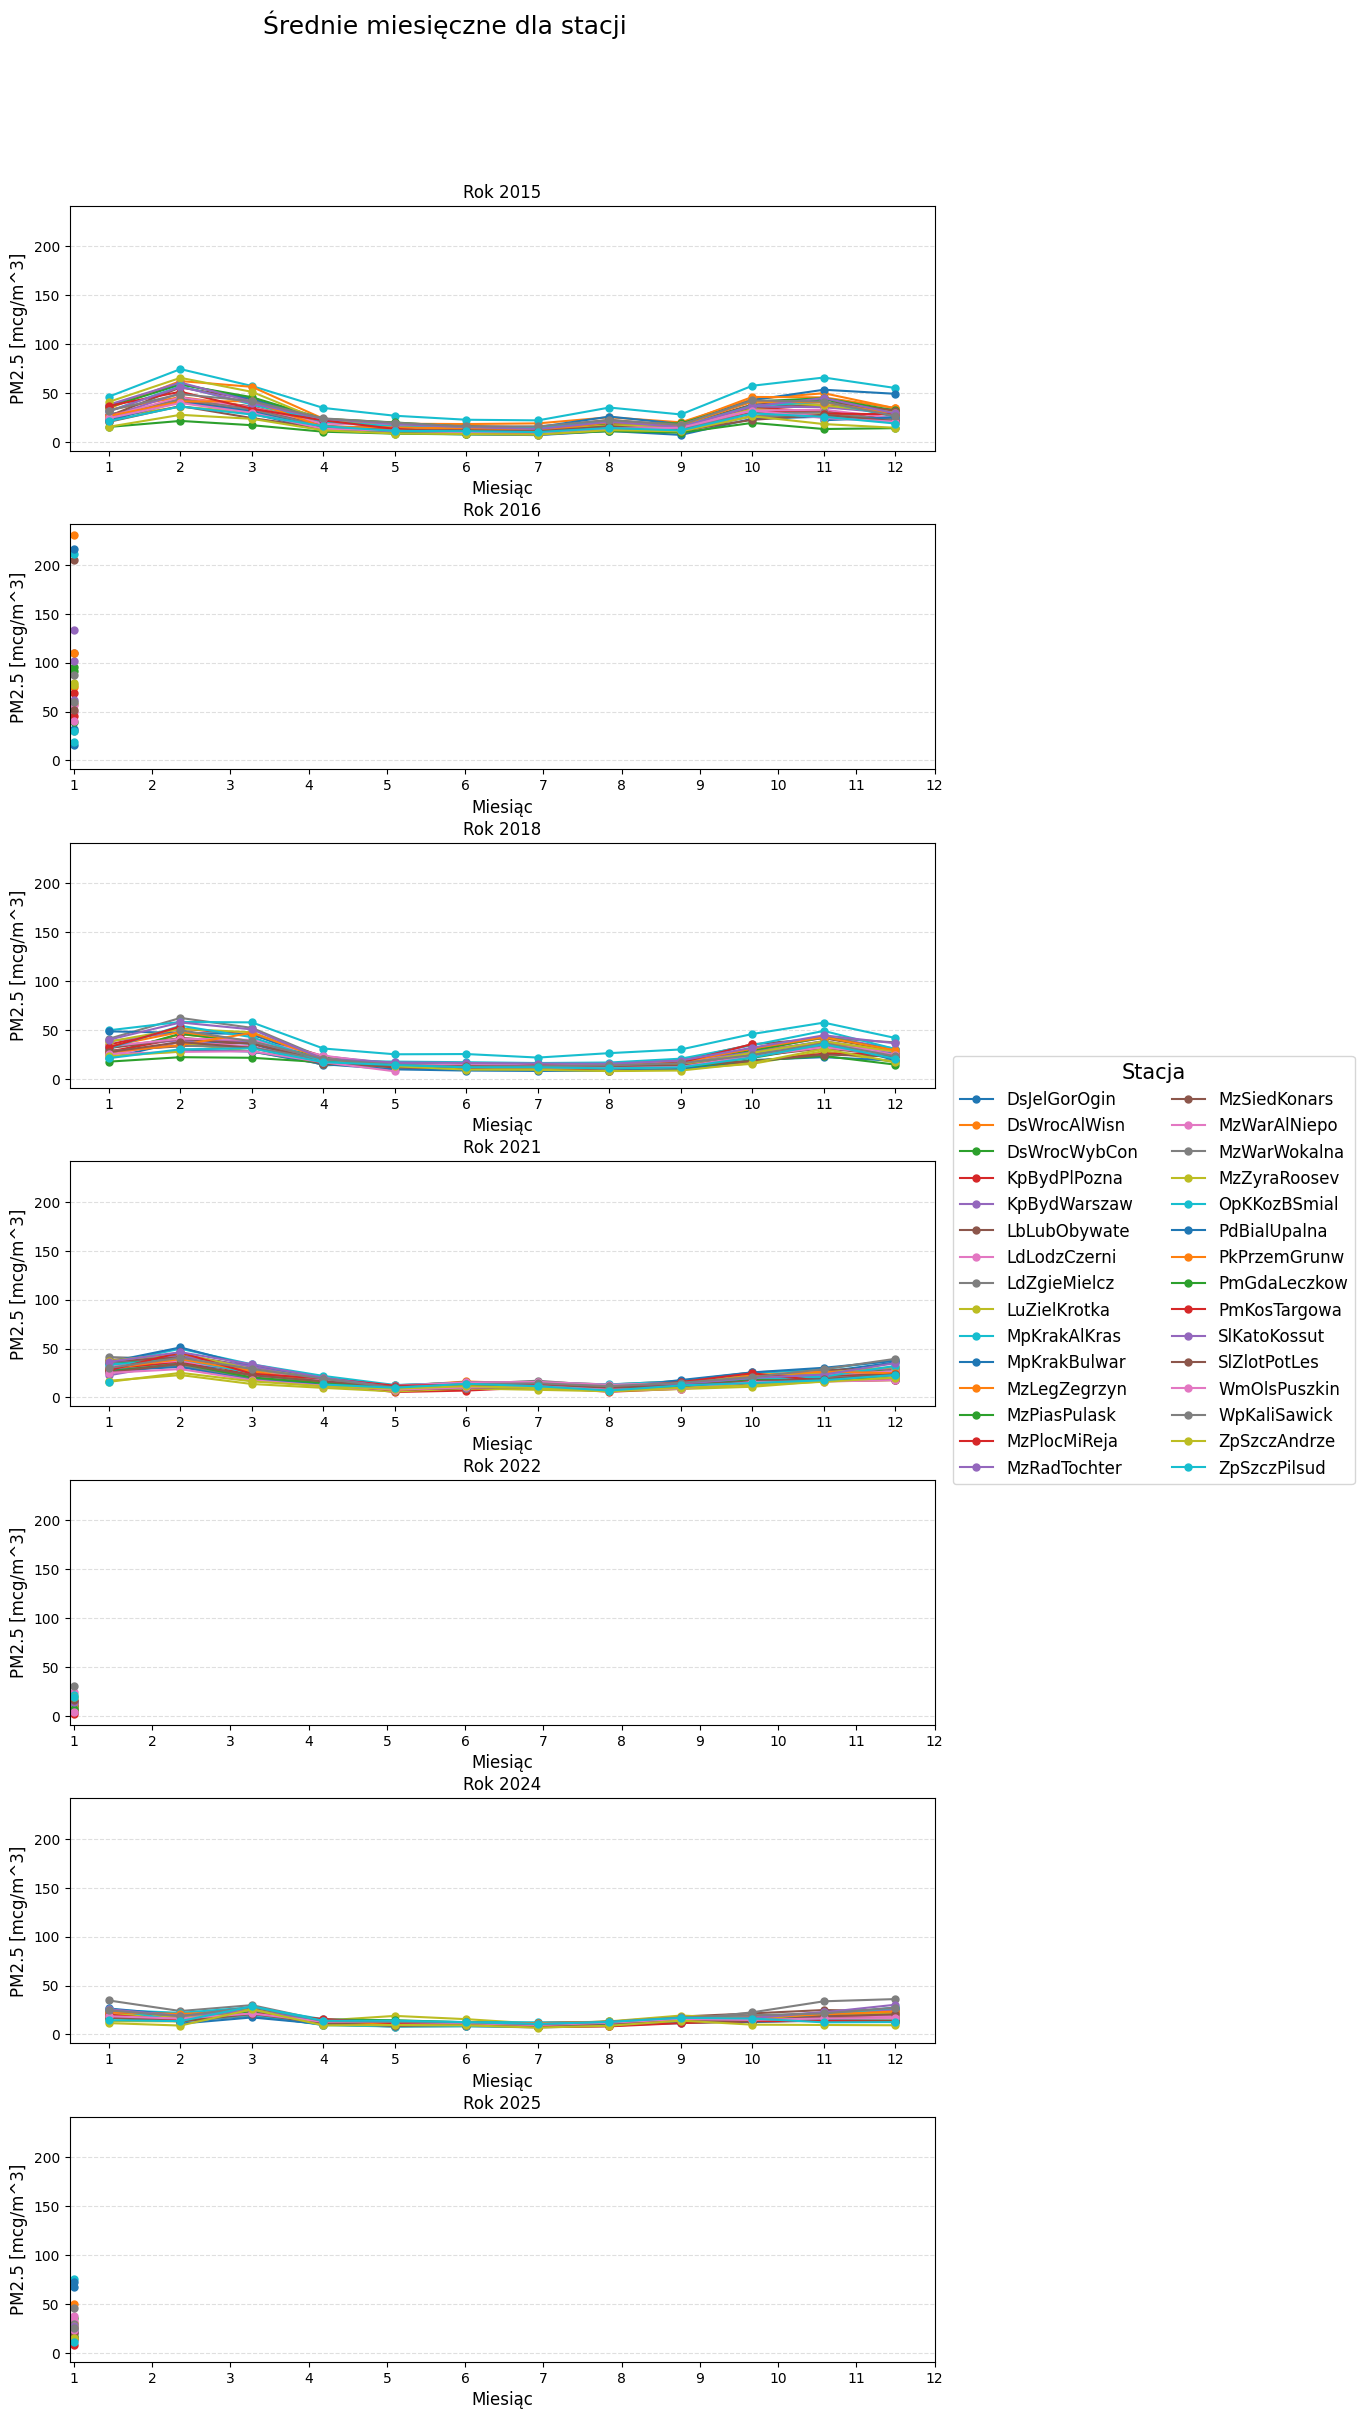

In [152]:
  plot_monthly_avg_station_per_year(
      monthly_avg_station,
      main_title="Średnie miesięczne dla stacji",
      main_title_y=0.95,
      main_title_fontsize=18,
      ncols=1,
      panel_size=(10, 4),
      hspace=0.30,
      wspace=0.0,
      label_fontsize=12,
      right_margin=0.99,
      legend_fontsize="large",
      legend_title_fontsize=15,
      sharey=True,
      sharex=False,
      marker_size=5
  )


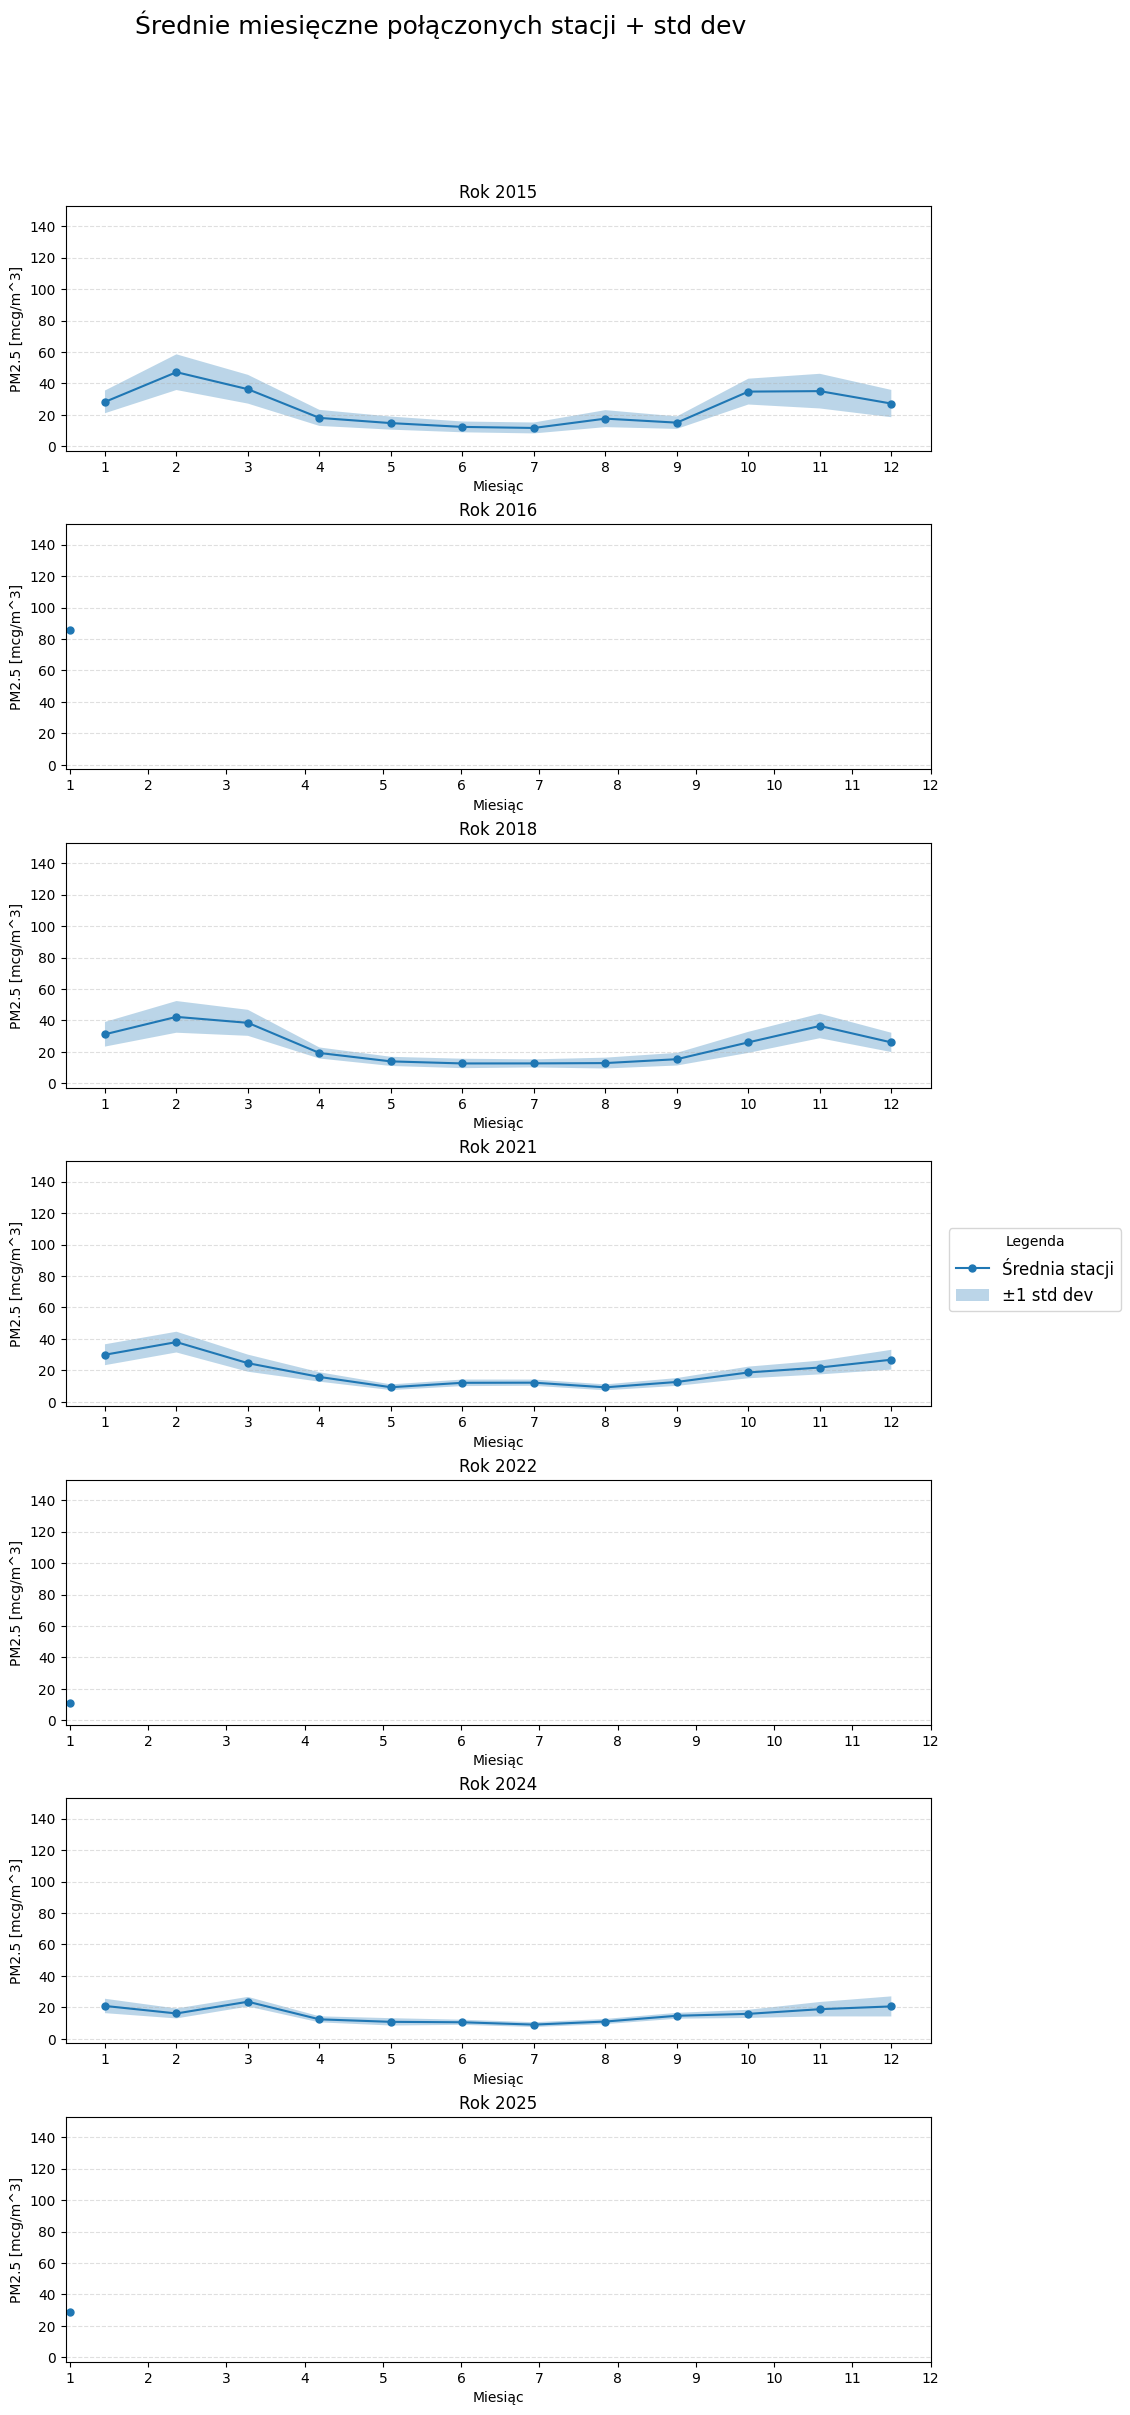

In [153]:
plot_monthly_avg_station_mean_std_per_year(
    monthly_avg_station,                                    
    main_title="Średnie miesięczne połączonych stacji + std dev",
    main_title_y=0.95,
    main_title_fontsize=18,
)


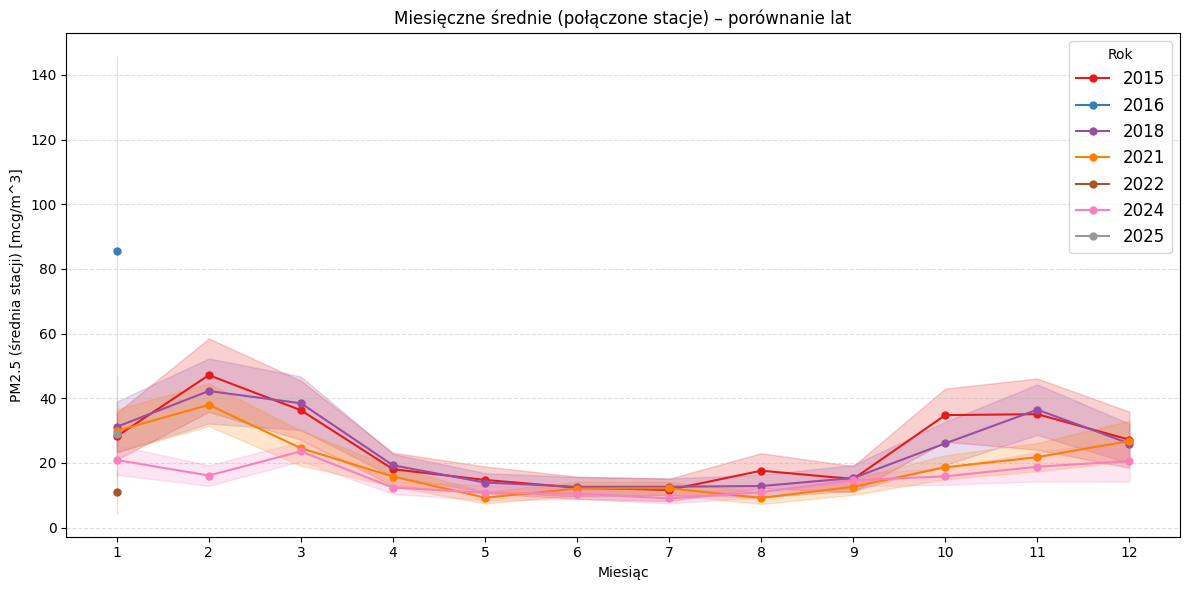

In [154]:
plot_monthly_avg_station_comparison(monthly_avg_station)


## Warszawa vs Katowice

In [164]:
city_data_combined = average_by_city(data_combined, metadata_combined)
city_data_combined.head()

/home/maxi7524/repositories/ZTP_projekt3/statistics_calculation.py:316: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_city = df.groupby(axis=1, by=col_cities).mean()


,Białystok,Bydgoszcz,Gdańsk,Jelenia Góra,Kalisz,Katowice,Kościerzyna,Kraków,Kędzierzyn-Koźle,Legionowo,...,Radom,Siedlce,Szczecin,Warszawa,Wrocław,Zgierz,Zielona Góra,Złoty Potok,Łódź,Żyrardów
2015-01-01 01:00:00.000,67.0,62.35,NaN,151.112,25.5,51.389,NaN,65.5,43.0000,49.5,...,55.465511,43.655099,NaN,70.401358,64.00000,58.690689,NaN,49.9464,59.73,86.182337
2015-01-01 02:00:00.000,103.0,56.60,75.52780,262.566,32.5,37.709,NaN,53.5,54.5611,92.1,...,40.666939,37.268873,148.61455,45.703354,37.91220,44.501255,51.8628,45.6291,185.92,61.823362
2015-01-01 03:00:00.005,49.0,15.85,8.87389,222.830,24.3,41.984,NaN,54.5,54.3000,42.7,...,38.452980,32.788982,26.73955,38.134642,27.86075,24.163937,15.8660,49.2093,54.25,58.974359
2015-01-01 04:00:00.010,37.0,11.50,8.83194,210.767,24.4,45.404,22.7895,56.5,48.4500,39.3,...,37.171214,31.263914,22.57205,34.547444,22.34455,19.516039,20.1187,53.3160,50.15,53.276353
2015-01-01 05:00:00.015,27.0,12.10,6.56750,191.211,25.0,36.854,NaN,53.5,48.7667,36.1,...,33.558964,31.263914,24.34690,30.492985,22.26675,16.850332,27.3413,51.5259,39.17,44.586895


In [165]:
monthly_avg_city = monthly_avg_with_nan_threshold(city_data_combined, max_nan_per_month=24*10)

In [166]:
monthly_avg_city

,Białystok,Bydgoszcz,Gdańsk,Jelenia Góra,Kalisz,Katowice,Kościerzyna,Kraków,Kędzierzyn-Koźle,Legionowo,...,Radom,Siedlce,Szczecin,Warszawa,Wrocław,Zgierz,Zielona Góra,Złoty Potok,Łódź,Żyrardów
2015-01-31,22.458108,24.092765,15.260864,24.520156,32.039201,31.268241,36.828669,42.272544,31.403195,34.310116,...,38.123273,23.887958,18.233387,24.918812,28.981688,26.391674,25.089723,20.487273,27.280364,40.945946
2015-02-28,40.958009,46.529372,21.431016,41.776451,48.865298,56.245705,51.306104,66.837065,56.960899,62.238146,...,60.710490,44.441037,31.929172,43.553308,44.047580,44.384155,35.990575,36.636730,41.191256,65.540673
2015-03-31,31.035422,32.213536,17.038034,28.692497,41.700835,39.502545,33.913686,51.400097,38.218824,56.327717,...,41.202075,36.093555,25.739361,34.122499,34.344681,35.936552,30.353802,24.345682,30.748028,51.168752
2015-04-30,13.417614,16.320839,10.382816,12.297509,24.006156,23.559511,21.983600,29.148512,20.981777,23.615797,...,20.452344,14.482860,13.883557,17.074328,17.737100,16.413105,15.546066,13.945945,15.312500,21.133324
2015-05-31,10.754224,13.251197,8.403376,8.736347,19.608522,18.075510,13.277275,23.608732,15.725602,19.384926,...,15.451546,14.829096,9.888142,16.173025,15.953118,10.143052,13.658251,11.579728,12.305898,18.701176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,13.641168,13.323542,16.036738,11.499001,17.346379,13.952917,11.497917,14.962986,12.173178,13.680417,...,15.648034,NaN,15.445833,14.522708,14.512569,14.975278,19.242817,13.544784,13.990510,14.369583
2024-10-31,12.582111,15.439906,14.073082,13.639892,19.594220,16.796909,13.457392,16.931116,12.983737,16.345222,...,17.620355,NaN,13.061089,15.332234,16.312030,22.537820,16.280614,13.948790,16.030956,16.498787
2024-11-30,14.234310,17.431293,13.720556,20.913194,21.413529,22.527222,13.683368,21.488889,19.233333,17.617251,...,22.761181,NaN,10.931944,17.714931,20.882083,33.833478,15.246218,18.436960,20.045175,19.548679
2024-12-31,13.624382,16.800000,13.875505,24.607930,27.382392,30.313441,13.167608,24.804099,27.602823,NaN,...,24.728962,NaN,10.916129,17.311694,25.648790,36.098148,12.692453,20.412903,21.659085,21.705242


Podano złe daty

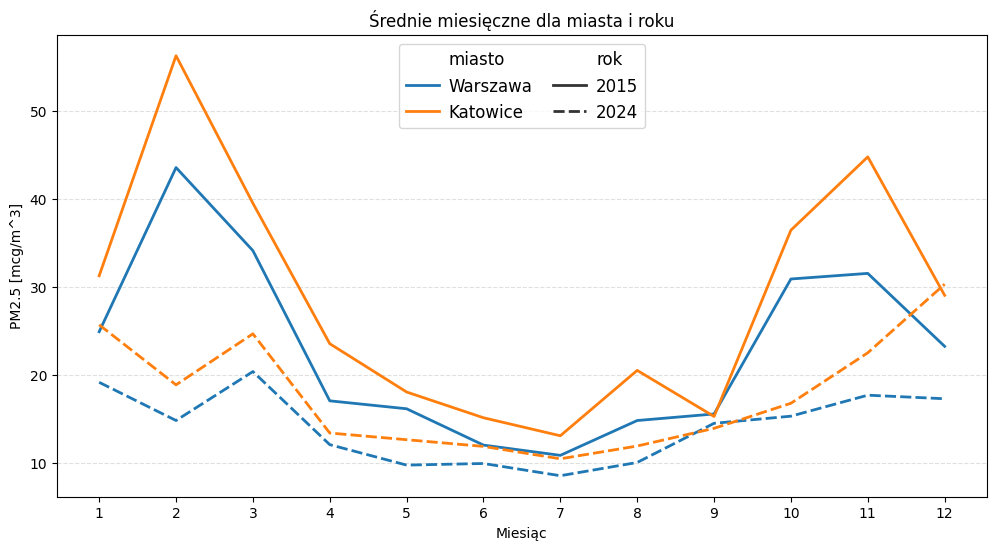

In [158]:
plot_city_monthly_averages(monthly_avg_city, ["Warszawa", "Katowice"], [2015, 2024])

## Heatmapy

Wprowadzono złe daty

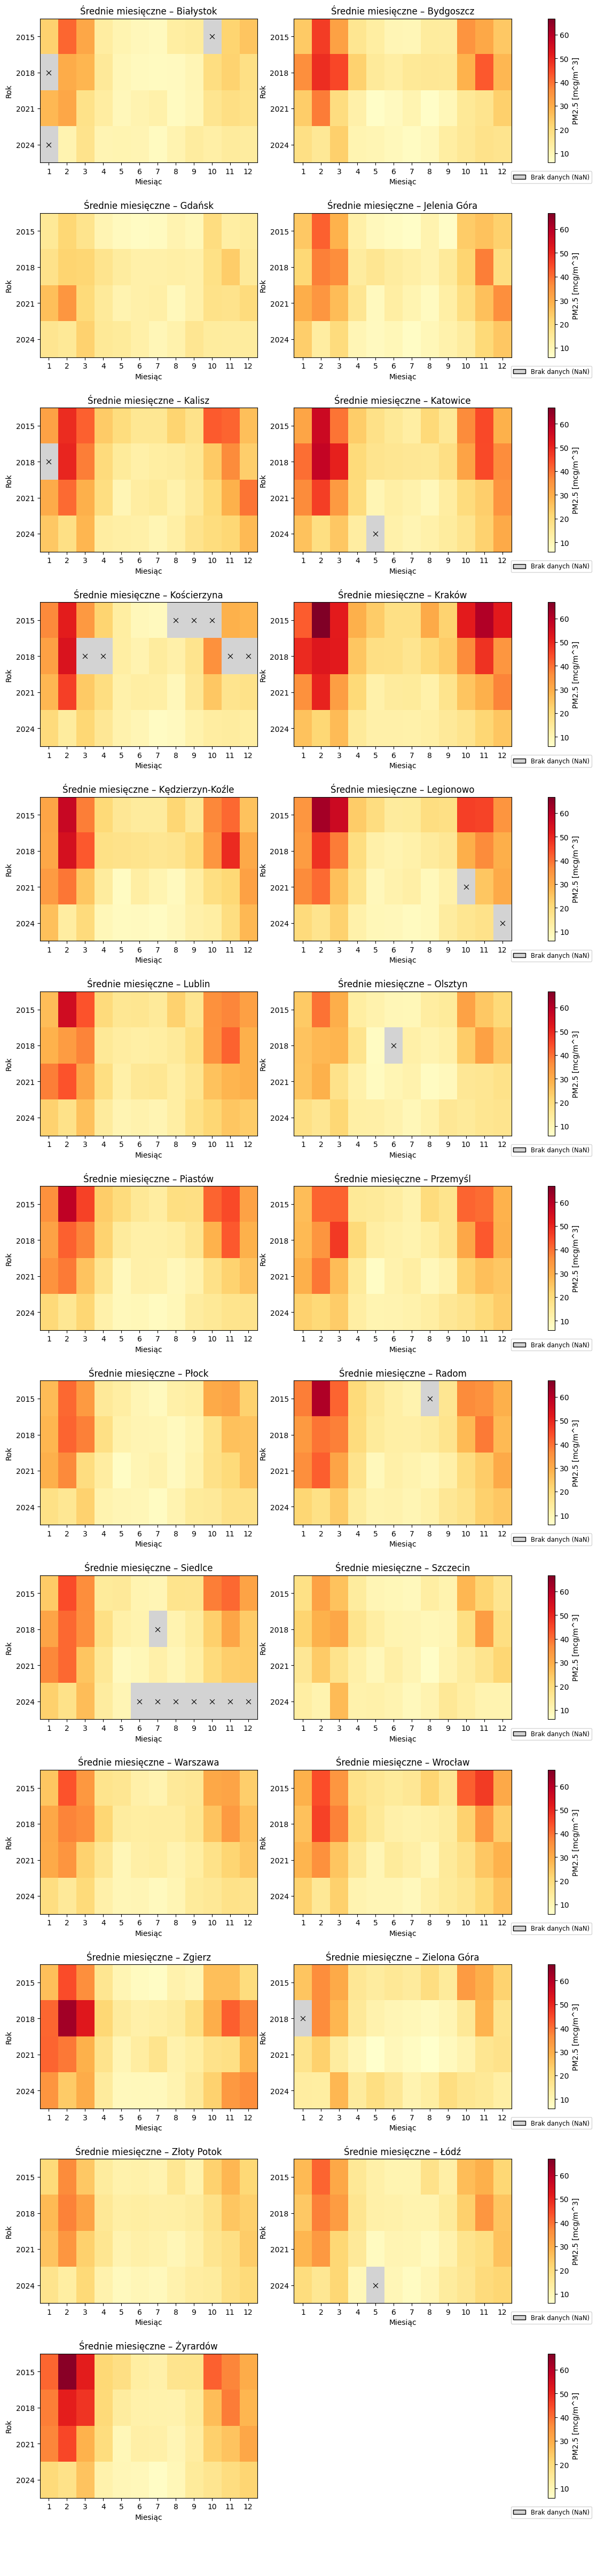

In [163]:
plot_city_monthly_heatmaps(
    monthly_avg_city,
    cities=city_data_combined.columns.to_list(),
    years=[2015, 2018, 2021, 2024],
    ncols=2,
)

## Przekroczenia norm

In [169]:
EXCLUDE_STATIONS = ["MzSiedKonars", "PmGdaLeczkow"] # wielomiesięczne przerwy w danych
days_over = count_days_over_threshold(data_combined.drop(EXCLUDE_STATIONS, axis=1), 15, years=(2015, 2018, 2021, 2024))
days_over

year,2015,2018,2021,2024
station,,,,
DsJelGorOgin,145,198,162,109
DsWrocAlWisn,310,232,211,134
DsWrocWybCon,199,195,157,130
KpBydPlPozna,190,239,125,108
KpBydWarszaw,163,237,119,123
LbLubObywate,275,234,246,170
LdLodzCzerni,202,205,175,128
LdZgieMielcz,178,251,201,189
LuZielKrotka,224,144,92,145


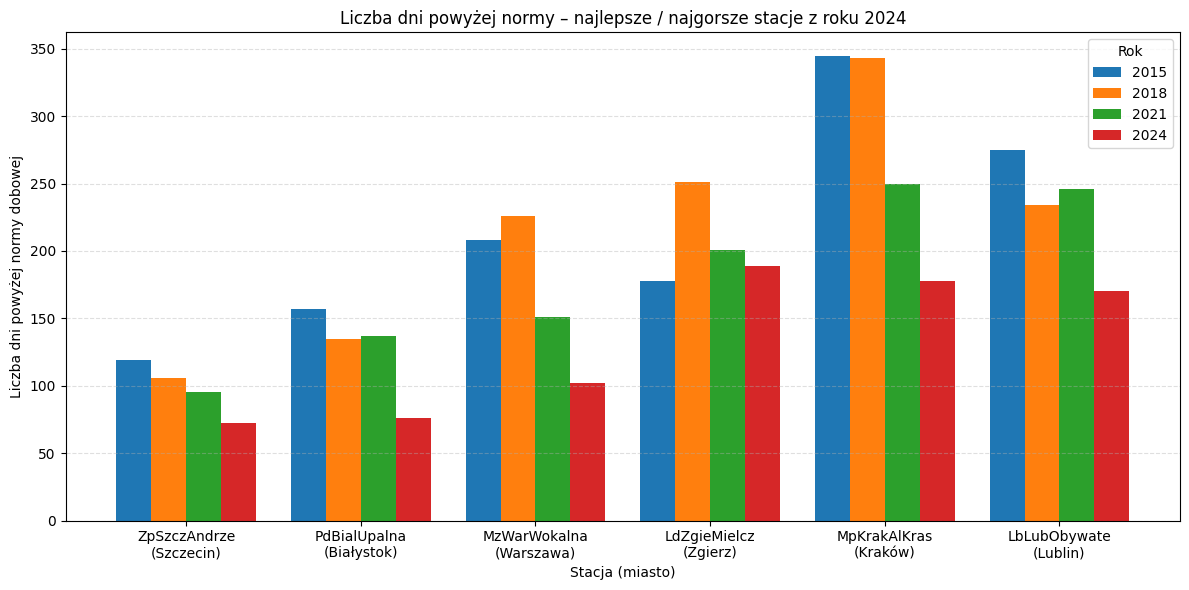

In [170]:
plot_extreme_stations_days_over(
    days_over,
    year_ref=2024,
    years=(2015, 2018, 2021, 2024),
    n=3,
    station_metadata=metadata_combined,
)


## Podsumowanie i Interpretacja

Na podstawie danych można stwierdzić, że sytuacja w zakresie stężenia pyłów **PM2.5** się poprawia na przestrzeni lat. Zdecydowanie widać pogorszenie sytuacji w okresie grzewczym, związanym z emisją pyłów przez prywatne ogrzewanie, które wedle mojej wiedzy, jest wysoko-emisje i przede-wszystkim odpowiedzialne za tak zwany smog. Widać tutaj skutek dotacji mających na celu wymienianie pieców cieplnych na nowoczesne.

Dodatkowo, sytuacja jest różna w różnych badanych regionach. Wynika to prawdopodobnie z czynników socjo-ekonomicznych (koszt wymiany pieca, ogrzewanie centralne, brak poczucia potrzeby dbania o środowisko), a także z uwarunkowania geograficznego (tj. faktu że niektóre miejscowości, są *uwięzione* przez uwarunkowanie terenowe, w taki sposób że zimą, podczas zwiększonej emisji, nie ma na tyle silnego wiatru, bądź jego kierunek nie pozwala na *wywianie* zanieczyszczeń)

### Suchy opis

- Progresywny spadek stężeń w kolejnych latach obserwowany w całym kraju - prawdopodobnie efekt zmian w technologiach grzewczych, spadek udziału paliw stałych (+ możliwe, że również łagodniejsze zimy)
- Silny efekt sezonowości - wzrost w miesiącach jesienno-zimowych - Prawdopodobnie wpływ "niskiej emisji" w sezonie grzewczym
- Wysokie zróżnicowanie stacji w miesiącach jesienno-zimowych, latem spadek we wszystkich stacjach do podobnego poziomu - Prawdopodobnie efekty zróżnicowanych lokalnie metod grzewczych, zróżnicowany udział paliw stałych i pieców starszej generacji
- Wspólny punkt odniesienia latem - prawdopodobnie efekt niższego zróżnicowania stałych źródeł zanieczyszczeń, głównie transportu
- Zróżnicowanie geograficzne: mniejsze poziomy w miejscowościach nadmorskich i na północy kraju (Gdańsk, Szczecin), wyróżniające się negatywnie miasta południa kraju (Kraków, Katowice)
- Ostatni wykres z przekroczeniami dziennymi również wskazuje że spadek stężeń występuje zarówno w "najlepszych" jak i "najgorszych" stacjach

## Zadanie 5

### Metodologia
Naszym celem jest określenie ilości dni które przekraczają norme ($15\mu g/m^3$). Uznawaliśmy, że dzień przekroczył normę, jeśli dowolna stacja w województwie przekroczyła próg.

### Wyniki
Widzimy, że w roku 2015, ilość przekroczonych dni wynosi średnio $\approx200$, w niektórych województwach jest to nawet $250-300$ dni. 

W latach 2021 i 2024, spadek dni z przekroczeniem normy wynosi średnio $\approx 100$ , najgorszej sprawa się ma w województwie Lubelskim, Lubuskim, Podkarpackim, Małopolskim i Wielkopolskim

### Wnioski
Widzimy że Uchwały antysmogowe oraz program "Czyste Powietrze" przynoszą skutki jeżeli chodzi  poprawe sytuacji. Możemy podejrzewać, że przekroczenia wynikają głównie z powodu nieprawidłowego ogrzewania mieszkań. Żeby to sprawdzić trzeba by podzielić dane na dwie grupy - sezon grzewczy i pozostałe. 



Nie możemy określic dokładnych przyczyn z powodu dużego zróżnicowania umiejscowienia stacji. 

Ważne jest zwrócenie uwagi na problem metodologiczny, ponieważ w przypadku województw z dużą ilością stacji pomiarowych, częściej otrzymamy pozytywny wynik przekroczenia normy. 


In [3]:
metadata_combined = pd.read_csv("cleaned_data/pd1_dataset_metadata.csv.xz")
data_combined = pd.read_csv("cleaned_data/pd1_dataset_data.csv.xz",index_col=0)
# DONE FORK: change format of index to datetime
data_combined.index = pd.to_datetime(data_combined.index, format='mixed')

# DONE FORK: apply format to df because of not being numeric, pandas aggregation functions does not work
mask_2018 = data_combined.index.year == 2018

data_combined.loc[mask_2018] = (
    data_combined.loc[mask_2018]
    .replace(",", ".", regex=True)
    .apply(pd.to_numeric, errors="coerce")
)
data_combined = data_combined.apply(pd.to_numeric, errors="coerce")

/tmp/ipykernel_666064/1629310555.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  data_combined = pd.read_csv("cleaned_data/pd1_dataset_data.csv.xz",index_col=0)


/home/maxi7524/repositories/ZTP_projekt3/visualizations.py:851: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  voiv_daily_over = daily_over.groupby(axis=1, level=0).all()


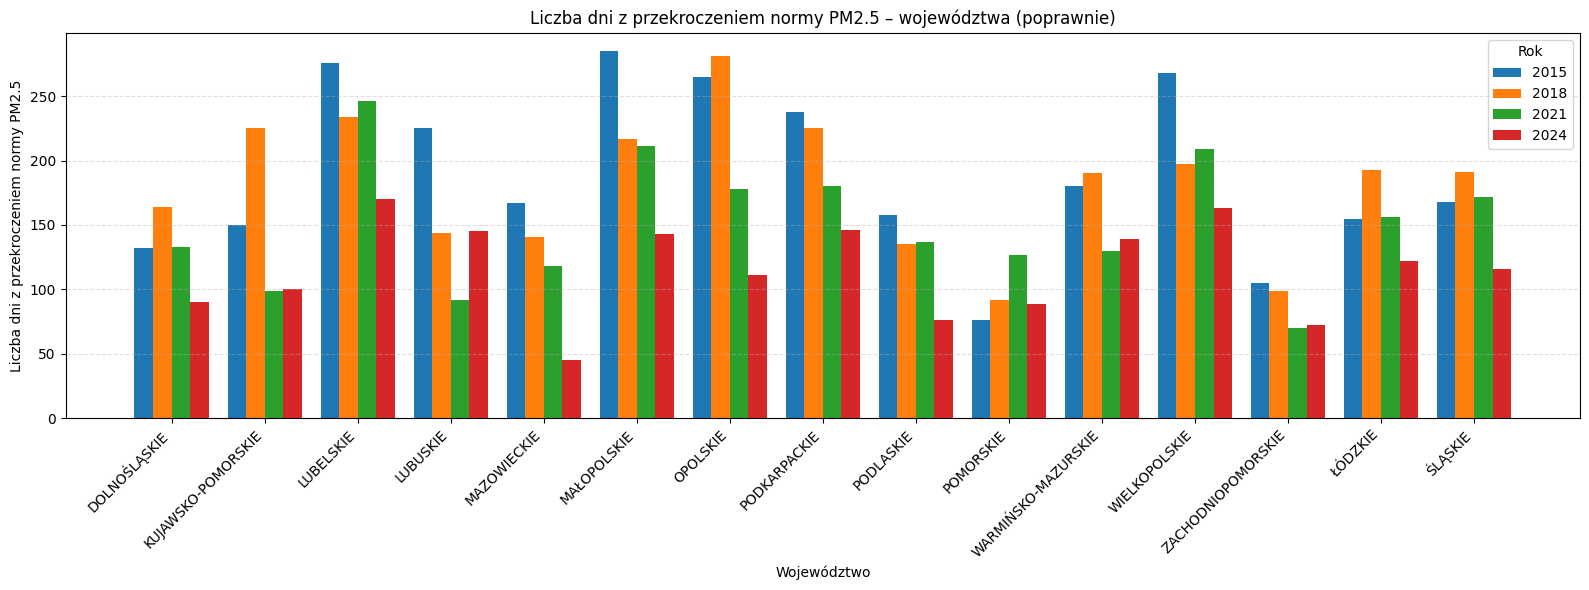

,2015,2018,2021,2024
DOLNOŚLĄSKIE,132,164,133,90
KUJAWSKO-POMORSKIE,150,225,99,100
LUBELSKIE,276,234,246,170
LUBUSKIE,225,144,92,145
MAZOWIECKIE,167,141,118,45
MAŁOPOLSKIE,285,217,211,143
OPOLSKIE,265,281,178,111
PODKARPACKIE,238,225,180,146
PODLASKIE,158,135,137,76
POMORSKIE,76,92,127,89


In [4]:
# Zadanie 5
from visualizations import plot_pm25_days_over_by_voivodeship_years

plot_pm25_days_over_by_voivodeship_years(
    meas_df=data_combined,
    metadata_df=metadata_combined,
    years=[2015, 2018, 2021, 2024],
    threshold=15
)
